
# Credit Card Default Prediction on Taiwan UCI Dataset — Reproduction Notebook

This notebook implements the **methodology described in the attached paper** on credit card default prediction:
- Preprocessing (drop duplicates, remove `ID`, check nulls)
- Exploratory Data Analysis (EDA): count plots, histograms, joint plots
- Dataset split into **train / validation / test**
- Models:
  - **ANN (Keras)** with hyperparameter sweeps over hidden layers, optimizers, and activation functions
  - **Decision Tree** with basic grid search
  - **AdaBoost** with basic grid search
- Evaluation metrics: **accuracy, precision, recall, F1-score** and confusion matrix
- Side-by-side comparison of the best configurations

> Source methodology reference (uploaded): Credit card default prediction using ML and DL techniques, *Internet of Things and Cyber-Physical Systems* (2024). fileciteturn0file0

> **Note**: This notebook is designed to run locally where you have `scikit-learn`, `pandas`, `matplotlib`, and (optionally) `tensorflow` installed.


In [12]:

# If needed, uncomment and run the following to install (CPU) TensorFlow and other deps.
# %pip install -q pandas numpy scikit-learn matplotlib seaborn tensorflow==2.*

import os
import math
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# TensorFlow is optional; ANN-related cells require it
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
    TF_AVAILABLE = True
except Exception as e:
    print("TensorFlow not available. ANN cells will be skipped unless you install it. Error:", e)
    TF_AVAILABLE = False

# Pretty printing options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 1000)

#suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Reproducibility seed
SEED = 42
np.random.seed(SEED)


In [13]:

# Path to the provided CSV (already uploaded alongside the PDF)
CSV_PATH = r"Taiwan_UCI_Credit_Card.csv"
assert Path(CSV_PATH).exists(), f"Dataset not found at: {CSV_PATH}"

df_raw = pd.read_csv(CSV_PATH)
print(df_raw.shape)
df_raw.head()


(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



## Dataset & Target
The dataset is the well-known **UCI Taiwan credit card default** dataset (30,000 rows, 25 columns in its original form).
The **target** is `default.payment.next.month` where `1 = default`, `0 = no default`.


In [14]:

TARGET_COL = "default.payment.next.month"
assert TARGET_COL in df_raw.columns, f"Target '{TARGET_COL}' not found. Columns: {list(df_raw.columns)}"

# Quick null/duplicate checks
print("Nulls per column (top 10 shown):")
display(df_raw.isna().sum().sort_values(ascending=False).head(10))

dup_count = df_raw.duplicated().sum()
print(f"Duplicate rows: {dup_count}")


Nulls per column (top 10 shown):


ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
dtype: int64

Duplicate rows: 0


In [15]:

df = df_raw.copy()

# 1) Remove duplicates (paper reports 35 duplicates)
df = df.drop_duplicates(ignore_index=True)

# 2) Remove unwanted 'ID' column if present
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# 3) Basic target sanity check (must be 0/1)
unique_targets = sorted(df[TARGET_COL].unique().tolist())
print("Unique target values:", unique_targets)

# 4) Report final shape
print("Final shape after preprocessing:", df.shape)
df.head()


Unique target values: [0, 1]
Final shape after preprocessing: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



## Exploratory Data Analysis (EDA)

Replicating the style in the paper:
- **Count plot** for the target
- **Count plot** for a categorical variable (e.g., `MARRIAGE`)
- **Histogram** for a bill amount column (e.g., `BILL_AMT6`)
- **Joint plot** (`BILL_AMT6` vs `PAY_AMT6`)

> Plots are indicative; your environment may render slightly differently.


Missing expected columns (OK if dataset variant): []


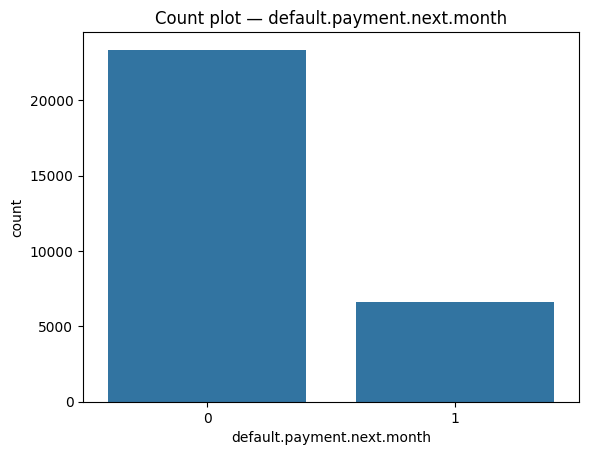

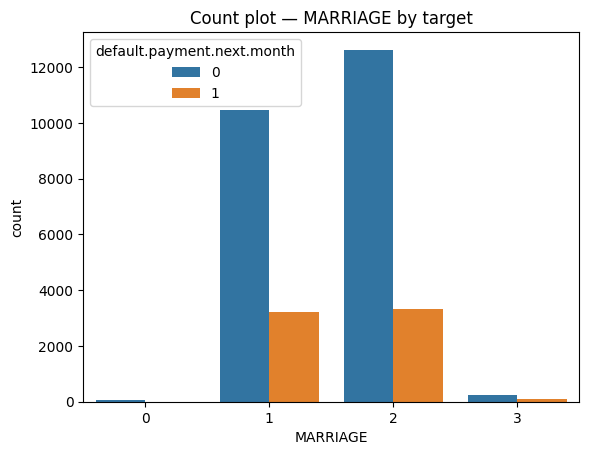

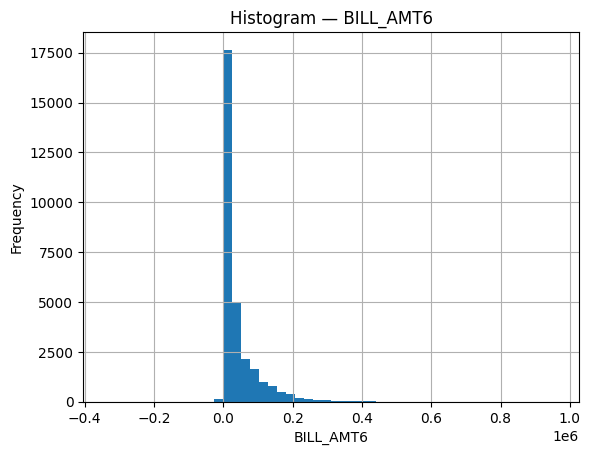

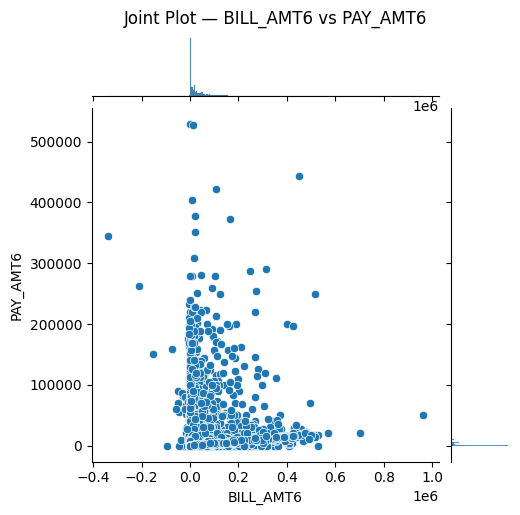

In [16]:

# Ensure typical columns exist (using standard UCI names)
expected_cols = [
    "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6",
    "BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
    "LIMIT_BAL"
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing expected columns (OK if dataset variant):", missing)

# Count plot: target
plt.figure()
sns.countplot(x=TARGET_COL, data=df)
plt.title("Count plot — default.payment.next.month")
plt.show()

# Count plot: MARRIAGE (if present)
if "MARRIAGE" in df.columns:
    plt.figure()
    sns.countplot(x="MARRIAGE", data=df, hue=TARGET_COL)
    plt.title("Count plot — MARRIAGE by target")
    plt.show()

# Histogram: BILL_AMT6 (if present)
if "BILL_AMT6" in df.columns:
    plt.figure()
    df["BILL_AMT6"].hist(bins=50)
    plt.title("Histogram — BILL_AMT6")
    plt.xlabel("BILL_AMT6")
    plt.ylabel("Frequency")
    plt.show()

# Joint plot: BILL_AMT6 vs PAY_AMT6 (if both available)
if {"BILL_AMT6", "PAY_AMT6"}.issubset(df.columns):
    sns.jointplot(data=df, x="BILL_AMT6", y="PAY_AMT6", kind="scatter", height=5)
    plt.suptitle("Joint Plot — BILL_AMT6 vs PAY_AMT6", y=1.02)
    plt.show()


In [17]:

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# First split: train vs (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=SEED, stratify=y
)
# Second split: val vs test (from temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

for name, arr in [("train", y_train), ("val", y_val), ("test", y_test)]:
    print(f"{name} size = {arr.shape[0]} | class balance ->",
          dict(pd.Series(arr).value_counts(normalize=True).round(3)))


train size = 18000 | class balance -> {0: np.float64(0.779), 1: np.float64(0.221)}
val size = 6000 | class balance -> {0: np.float64(0.779), 1: np.float64(0.221)}
test size = 6000 | class balance -> {0: np.float64(0.779), 1: np.float64(0.221)}


In [18]:

from dataclasses import dataclass, field

@dataclass
class EvalResult:
    model_name: str
    setting: str
    split: str
    accuracy: float
    precision_0: float
    recall_0: float
    f1_0: float
    precision_1: float
    recall_1: float
    f1_1: float

def evaluate(model, X, y, model_name: str, setting: str, split: str):
    y_pred = model.predict(X)
    if hasattr(y_pred, "toarray"):
        y_pred = y_pred.toarray()
    # For classifiers returning probabilities
    if y_pred.ndim != 1:
        if y_pred.shape[1] == 1:
            y_pred = (y_pred.ravel() > 0.5).astype(int)
        else:
            y_pred = y_pred.argmax(axis=1)
    report = classification_report(y, y_pred, output_dict=True, zero_division=0)
    res = EvalResult(
        model_name=model_name,
        setting=setting,
        split=split,
        accuracy=report["accuracy"],
        precision_0=report.get("0",{}).get("precision",0.0),
        recall_0=report.get("0",{}).get("recall",0.0),
        f1_0=report.get("0",{}).get("f1-score",0.0),
        precision_1=report.get("1",{}).get("precision",0.0),
        recall_1=report.get("1",{}).get("recall",0.0),
        f1_1=report.get("1",{}).get("f1-score",0.0),
    )
    return res, report

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

results = []
def add_result(res):
    global results
    results.append(res)

def results_df():
    return pd.DataFrame([r.__dict__ for r in results])


In [19]:

dt = DecisionTreeClassifier(random_state=SEED)
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 15, 25],
    "min_samples_split": [5, 7, 9, 10],
}

grid_dt = GridSearchCV(dt, param_grid_dt, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)
print("DT best params:", grid_dt.best_params_)
print("DT best CV accuracy:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

# Evaluate
for split_name, (XX, yy) in [("val", (X_val, y_val)), ("test", (X_test, y_test))]:
    res, report = evaluate(best_dt, XX, yy, "DecisionTree", json.dumps(grid_dt.best_params_), split_name)
    add_result(res)
    print(f"\n=== DecisionTree ({split_name}) ===")
    print(pd.DataFrame(report).T)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
DT best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}
DT best CV accuracy: 0.8224999999999999

=== DecisionTree (val) ===
              precision    recall  f1-score      support
0              0.834023  0.948427  0.887554  4673.000000
1              0.648688  0.335343  0.442126  1327.000000
accuracy       0.812833  0.812833  0.812833     0.812833
macro avg      0.741356  0.641885  0.664840  6000.000000
weighted avg   0.793033  0.812833  0.789040  6000.000000

=== DecisionTree (test) ===
              precision    recall  f1-score      support
0              0.839735  0.949711  0.891344  4673.000000
1              0.671329  0.361718  0.470127  1327.000000
accuracy       0.819667  0.819667  0.819667     0.819667
macro avg      0.755532  0.655715  0.680735  6000.000000
weighted avg   0.802489  0.819667  0.798185  6000.000000


In [20]:

ada = AdaBoostClassifier(random_state=SEED)
param_grid_ada = {
    "algorithm": ["SAMME", "SAMME.R"],
    "n_estimators": [50, 60, 70, 100],
    "learning_rate": [1.0, 1.1, 1.2, 1.3],
}
grid_ada = GridSearchCV(ada, param_grid_ada, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
grid_ada.fit(X_train, y_train)
print("AdaBoost best params:", grid_ada.best_params_)
print("AdaBoost best CV accuracy:", grid_ada.best_score_)

best_ada = grid_ada.best_estimator_

for split_name, (XX, yy) in [("val", (X_val, y_val)), ("test", (X_test, y_test))]:
    res, report = evaluate(best_ada, XX, yy, "AdaBoost", json.dumps(grid_ada.best_params_), split_name)
    add_result(res)
    print(f"\n=== AdaBoost ({split_name}) ===")
    print(pd.DataFrame(report).T)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 1.3, 'n_estimators': 60}
AdaBoost best CV accuracy: 0.8203333333333332

=== AdaBoost (val) ===
              precision    recall  f1-score      support
0              0.829314  0.956559  0.888403  4673.000000
1              0.667213  0.306707  0.420237  1327.000000
accuracy       0.812833  0.812833  0.812833     0.812833
macro avg      0.748263  0.631633  0.654320  6000.000000
weighted avg   0.793462  0.812833  0.784860  6000.000000

=== AdaBoost (test) ===
              precision    recall  f1-score    support
0              0.835949  0.957415  0.892569  4673.0000
1              0.692901  0.338357  0.454684  1327.0000
accuracy       0.820500  0.820500  0.820500     0.8205
macro avg      0.764425  0.647886  0.673626  6000.0000
weighted avg   0.804312  0.820500  0.795723  6000.0000



## Artificial Neural Network (ANN) — Keras

We replicate the paper's approach:
- Start with a baseline ANN (sequential, several hidden layers)
- Sweep **hidden layers** = {3, 4, 5}
- Sweep **optimizers** = {`adam`, `sgd`, `rmsprop`, `adamax`}
- Sweep **activations** = {`relu`, `sigmoid`, `tanh`, `elu`}

> **Runtime caution**: ANN sweeps can be slow. You can toggle the switches in the next cell to control what to run.


In [21]:

RUN_BASELINE_ANN = True
RUN_HIDDEN_LAYERS_SWEEP = True
RUN_OPTIMIZER_SWEEP = True
RUN_ACTIVATION_SWEEP = True

EPOCHS = 20
BATCH_SIZE = 32

def make_ann(input_dim: int, hidden_layers=[64,32,32,16,16], activation="relu", optimizer="adam"):
    model = Sequential()
    # First hidden
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    # Additional hidden
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
    # Output
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

def fit_eval_keras(model, X_tr, y_tr, X_eval, y_eval, split_name, model_name, setting):
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_eval, y_eval),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    # Evaluate on split sets we care about
    for sname, (XX, yy) in [("val",(X_val,y_val)), ("test",(X_test,y_test))]:
        y_prob = model.predict(XX, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        report = classification_report(yy, y_pred, output_dict=True, zero_division=0)
        res = EvalResult(
            model_name=model_name,
            setting=setting,
            split=sname,
            accuracy=report["accuracy"],
            precision_0=report.get("0",{}).get("precision",0.0),
            recall_0=report.get("0",{}).get("recall",0.0),
            f1_0=report.get("0",{}).get("f1-score",0.0),
            precision_1=report.get("1",{}).get("precision",0.0),
            recall_1=report.get("1",{}).get("recall",0.0),
            f1_1=report.get("1",{}).get("f1-score",0.0),
        )
        add_result(res)
        print(f"\n=== {model_name} ({sname}) ===")
        print(pd.DataFrame(report).T)
    return hist


In [22]:

if TF_AVAILABLE:
    input_dim = X_train.shape[1]

    # Baseline (approx paper default)
    if RUN_BASELINE_ANN:
        baseline_layers = [64,32,32,16,16]  # 5 hidden layers
        baseline_activation = "relu"
        baseline_optimizer = "adamax"
        model = make_ann(input_dim, hidden_layers=baseline_layers,
                         activation=baseline_activation, optimizer=baseline_optimizer)
        _ = fit_eval_keras(model, X_train, y_train, X_val, y_val,
                           split_name="val", model_name="ANN_baseline",
                           setting=json.dumps(dict(layers=baseline_layers, act=baseline_activation, opt=baseline_optimizer)))
    else:
        print("Skipping baseline ANN")

    # Hidden layer sweep
    if RUN_HIDDEN_LAYERS_SWEEP:
        for layers in ([64,32,32], [64,32,32,16], [64,32,32,16,16]):
            model = make_ann(input_dim, hidden_layers=layers, activation="relu", optimizer="adam")
            _ = fit_eval_keras(model, X_train, y_train, X_val, y_val,
                               split_name="val", model_name="ANN_layers_sweep",
                               setting=json.dumps(dict(layers=layers, act="relu", opt="adam")))
    else:
        print("Skipping hidden layer sweep")

    # Optimizer sweep
    if RUN_OPTIMIZER_SWEEP:
        for opt in ["adam", "sgd", "rmsprop", "adamax"]:
            model = make_ann(input_dim, hidden_layers=[64,32,32,16,16], activation="relu", optimizer=opt)
            _ = fit_eval_keras(model, X_train, y_train, X_val, y_val,
                               split_name="val", model_name="ANN_optimizer_sweep",
                               setting=json.dumps(dict(layers=[64,32,32,16,16], act="relu", opt=opt)))
    else:
        print("Skipping optimizer sweep")

    # Activation sweep
    if RUN_ACTIVATION_SWEEP:
        for act in ["sigmoid", "relu", "elu", "tanh"]:
            model = make_ann(input_dim, hidden_layers=[64,32,32,16,16], activation=act, optimizer="adam")
            _ = fit_eval_keras(model, X_train, y_train, X_val, y_val,
                               split_name="val", model_name="ANN_activation_sweep",
                               setting=json.dumps(dict(layers=[64,32,32,16,16], act=act, opt="adam")))
    else:
        print("Skipping activation sweep")
else:
    print("TensorFlow not available; skipping ANN experiments. Install TF to run.")



=== ANN_baseline (val) ===
              precision    recall  f1-score      support
0              0.784354  0.978386  0.870691  4673.000000
1              0.409357  0.052751  0.093458  1327.000000
accuracy       0.773667  0.773667  0.773667     0.773667
macro avg      0.596855  0.515569  0.482075  6000.000000
weighted avg   0.701417  0.773667  0.698793  6000.000000

=== ANN_baseline (test) ===
              precision    recall  f1-score    support
0              0.783887  0.970255  0.867170  4673.0000
1              0.356481  0.058026  0.099806  1327.0000
accuracy       0.768500  0.768500  0.768500     0.7685
macro avg      0.570184  0.514140  0.483488  6000.0000
weighted avg   0.689359  0.768500  0.697455  6000.0000

=== ANN_layers_sweep (val) ===
              precision    recall  f1-score      support
0              0.778833  1.000000  0.875668  4673.000000
1              0.000000  0.000000  0.000000  1327.000000
accuracy       0.778833  0.778833  0.778833     0.778833
macro avg  

In [23]:

df_results = results_df().sort_values(by=["model_name","split","accuracy"], ascending=[True, True, False])
display(df_results.head(50))

# Best per model on the test split
best_by_model = (
    df_results[df_results["split"]=="test"]
    .sort_values(["model_name","accuracy"], ascending=[True,False])
    .groupby("model_name")
    .head(1)
    .reset_index(drop=True)
)
print("=== Best configurations per model (test split) ===")
display(best_by_model)


,model_name,setting,split,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
21,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""sigmo...",test,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
25,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""elu"",...",test,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
27,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""tanh""...",test,0.778667,0.778796,0.999786,0.875562,0.000000,0.000000,0.000000
23,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",test,0.778500,0.778760,0.999572,0.875457,0.000000,0.000000,0.000000
20,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""sigmo...",val,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
24,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""elu"",...",val,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
26,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""tanh""...",val,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
22,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",val,0.778667,0.778796,0.999786,0.875562,0.000000,0.000000,0.000000
5,ANN_baseline,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",test,0.768500,0.783887,0.970255,0.867170,0.356481,0.058026,0.099806
4,ANN_baseline,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",val,0.773667,0.784354,0.978386,0.870691,0.409357,0.052751,0.093458


=== Best configurations per model (test split) ===


,model_name,setting,split,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
0,ANN_activation_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""sigmo...",test,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
1,ANN_baseline,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",test,0.768500,0.783887,0.970255,0.867170,0.356481,0.058026,0.099806
2,ANN_layers_sweep,"{""layers"": [64, 32, 32], ""act"": ""relu"", ""opt"":...",test,0.778833,0.778833,1.000000,0.875668,0.000000,0.000000,0.000000
3,ANN_optimizer_sweep,"{""layers"": [64, 32, 32, 16, 16], ""act"": ""relu""...",test,0.779167,0.779186,0.999786,0.875808,0.750000,0.002261,0.004508
4,AdaBoost,"{""algorithm"": ""SAMME"", ""learning_rate"": 1.3, ""...",test,0.820500,0.835949,0.957415,0.892569,0.692901,0.338357,0.454684
5,DecisionTree,"{""criterion"": ""gini"", ""max_depth"": 5, ""min_sam...",test,0.819667,0.839735,0.949711,0.891344,0.671329,0.361718,0.470127


In [24]:

OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "results_summary.csv"
df_results.to_csv(out_path, index=False)
print("Saved:", out_path.resolve())


Saved: C:\Users\Arnav\Documents\00 Phd databases\data\complete\Taiwan_UCI_Credit_Card\outputs\results_summary.csv
